# House Property Sales

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

In [4]:
# Load Dataset
sales = pd.read_csv('data/raw_sales.csv')

sales.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [5]:
# Convert 'datesold' column to datetime, removing the time part
sales['datesold'] = pd.to_datetime(sales['datesold']).dt.date

# Set the 'datesold' column as the index
sales.set_index('datesold', inplace=True)

# Display the updated DataFrame
sales.head()

,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-07,2607,525000,house,4
2007-02-27,2906,290000,house,3
2007-03-07,2905,328000,house,3
2007-03-09,2905,380000,house,4
2007-03-21,2906,310000,house,3


In [6]:
# Display unique values in the 'bedrooms' column
unique_bedrooms = sales['bedrooms'].unique()
print(unique_bedrooms)

[4 3 5 1 2 0]


In [7]:
# Count the number of rows for each value in the 'bedrooms' column
bedroom_counts = sales['bedrooms'].value_counts().sort_index()

# Display the counts
bedroom_counts

bedrooms
0       30
1     1627
2     3598
3    11933
4    10442
5     1950
Name: count, dtype: int64

In [8]:
# Create a subset DataFrame where bedrooms = 3
bed3 = sales[sales['bedrooms'] == 3]

# Display the first few rows of the subset
bed3.head()

,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-27,2906,290000,house,3
2007-03-07,2905,328000,house,3
2007-03-21,2906,310000,house,3
2007-04-24,2607,399000,house,3
2007-05-24,2902,359000,house,3


In [9]:
bed3.tail()

,postcode,price,propertyType,bedrooms
datesold,,,,
2019-07-04,2617,457500,unit,3
2019-07-18,2601,560000,unit,3
2019-07-23,2914,450000,unit,3
2019-07-23,2912,549950,unit,3
2019-07-25,2900,500000,unit,3


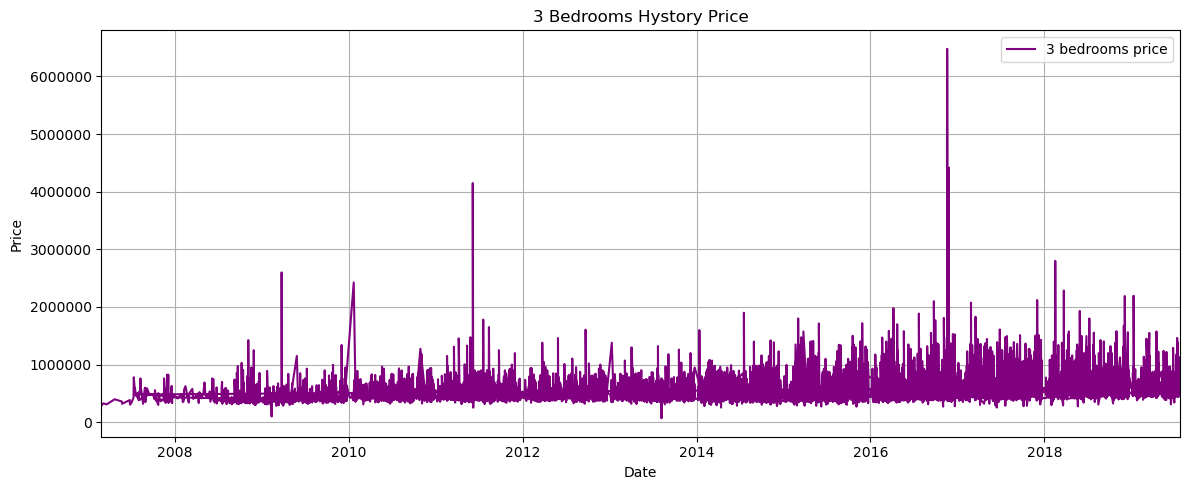

In [10]:
# Plot Graph
plt.figure(figsize=(12, 5))                                      

plt.plot(bed3.index, bed3['price'], label='3 bedrooms price', color= 'purple')     

plt.title('3 Bedrooms Hystory Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2007-02-27'), pd.to_datetime('2019-07-25'))

# Set y-axis to avoid scientific notation
plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [11]:
# Ensure that the index is in datetime format
bed3.index = pd.to_datetime(bed3.index)

# Drop unnecessary columns
bed3 = bed3.drop(['postcode', 'propertyType', 'bedrooms'], axis=1)

# Resample by month and calculate the average of 'price'
bed3m = bed3.resample('M').mean().round(2)

# Show the result
bed3m.head()

,price
datesold,
2007-02-28,290000.0
2007-03-31,319000.0
2007-04-30,399000.0
2007-05-31,339500.0
2007-06-30,345000.0


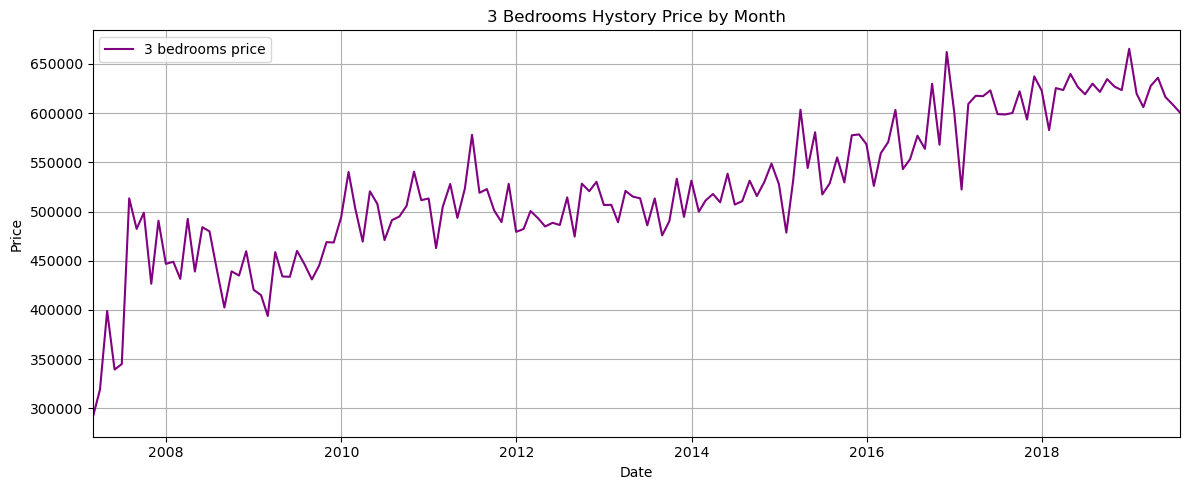

In [12]:
# Plot Graph
plt.figure(figsize=(12, 5))                                      

plt.plot(bed3m.index, bed3m['price'], label='3 bedrooms price', color= 'purple')     

plt.title('3 Bedrooms Hystory Price by Month')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2007-02-28'), pd.to_datetime('2019-07-31'))

# Set y-axis to avoid scientific notation
plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

# SARIMA

In [13]:
# Split the data
cutoff = pd.to_datetime("2018-01-01")

train = bed3m[bed3m.index < cutoff]
test = bed3m[bed3m.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (131, 1)
Test shape: (19, 1)

                price
datesold             
2017-08-31  600104.91
2017-09-30  622123.16
2017-10-31  593466.56
2017-11-30  637271.15
2017-12-31  622931.88

                price
datesold             
2018-01-31  582655.10
2018-02-28  625418.85
2018-03-31  623425.33
2018-04-30  639740.24
2018-05-31  626453.34


In [14]:
hou_series = train['price']

In [15]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(hou_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.1209, p-value = 0.7067
d = 1 | ADF Statistic = -7.9978, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [16]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(hou_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 1


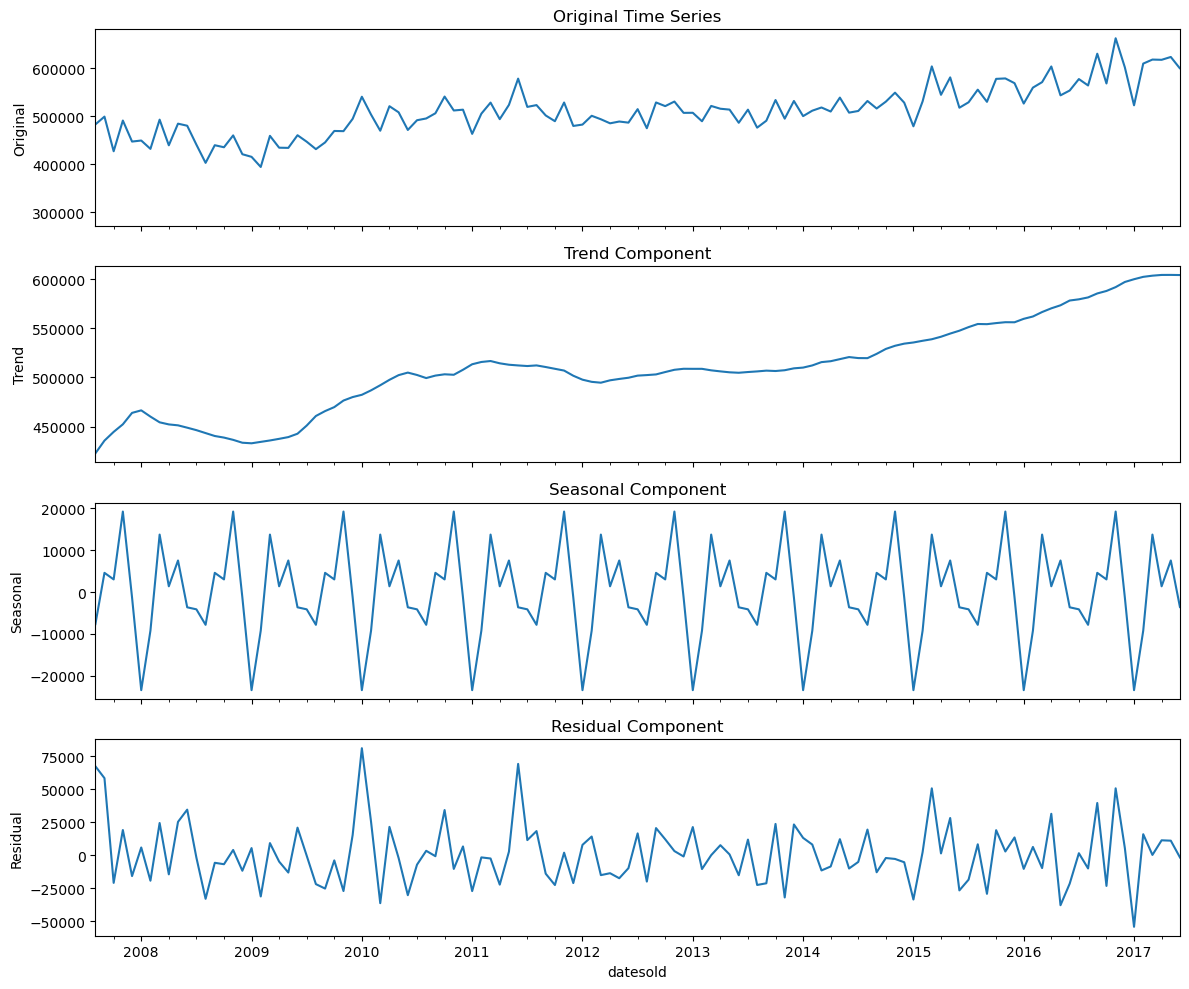

In [17]:
result = seasonal_decompose(hou_series, model='aditive', period=12)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [18]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    hou_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # Seasonal period
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(1, 1, 0)(0, 0, 0, 12)


In [19]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]       # Define search ranges for non-seasonal parameters (p, q)
P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]         # Define search ranges for seasonal parameters (P, Q)
d = 1
D = 0
S = 12

total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(hou_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,model
0,115,"(1, 1, 3)","(0, 0, 3)",2095.319053,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,243,"(3, 1, 3)","(0, 0, 3)",2097.686789,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,187,"(2, 1, 3)","(2, 0, 3)",2097.882385,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,119,"(1, 1, 3)","(1, 0, 3)",2098.529751,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,251,"(3, 1, 3)","(2, 0, 3)",2098.590401,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


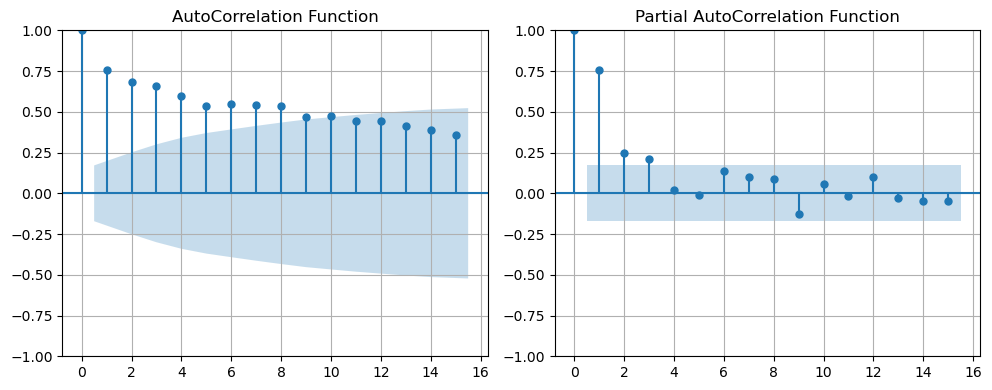

In [20]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Plot AutoCorrelation Function
plot_acf(hou_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Plot Partial Autocorrelation Function
plot_pacf(hou_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_113 = SARIMAX(hou_series,                      # Time series data
                    order=(1, 1, 3),                 # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 3, 12),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)      # Allow non-stationary behavior

# Fit the model
model_fit_113 = model_113.fit()

# Display summary of the model
print(model_fit_113.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  131
Model:             SARIMAX(1, 1, 3)x(0, 0, 3, 12)   Log Likelihood               -1039.660
Date:                            Fri, 09 May 2025   AIC                           2095.319
Time:                                    08:34:23   BIC                           2115.318
Sample:                                02-28-2007   HQIC                          2103.384
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9277      0.049     19.107      0.000       0.833       1.023
ma.L1         -1.9808      0.186   

In [22]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_113)

ma.L3 coefficient: -0.0301
ma.L3 95% CI: (-0.3816, 0.3215)
ma.L3 p-value: 0.8668
ma.L3 is statistically IRRELEVANT in the model.

ma.S.L12 coefficient: 0.0685
ma.S.L12 95% CI: (-0.1927, 0.3297)
ma.S.L12 p-value: 0.6073
ma.S.L12 is statistically IRRELEVANT in the model.

ma.S.L24 coefficient: 0.2172
ma.S.L24 95% CI: (-0.0110, 0.4454)
ma.S.L24 p-value: 0.0622
ma.S.L24 is statistically IRRELEVANT in the model.

ma.S.L36 coefficient: 0.1162
ma.S.L36 95% CI: (-0.0633, 0.2957)
ma.S.L36 p-value: 0.2044
ma.S.L36 is statistically IRRELEVANT in the model.



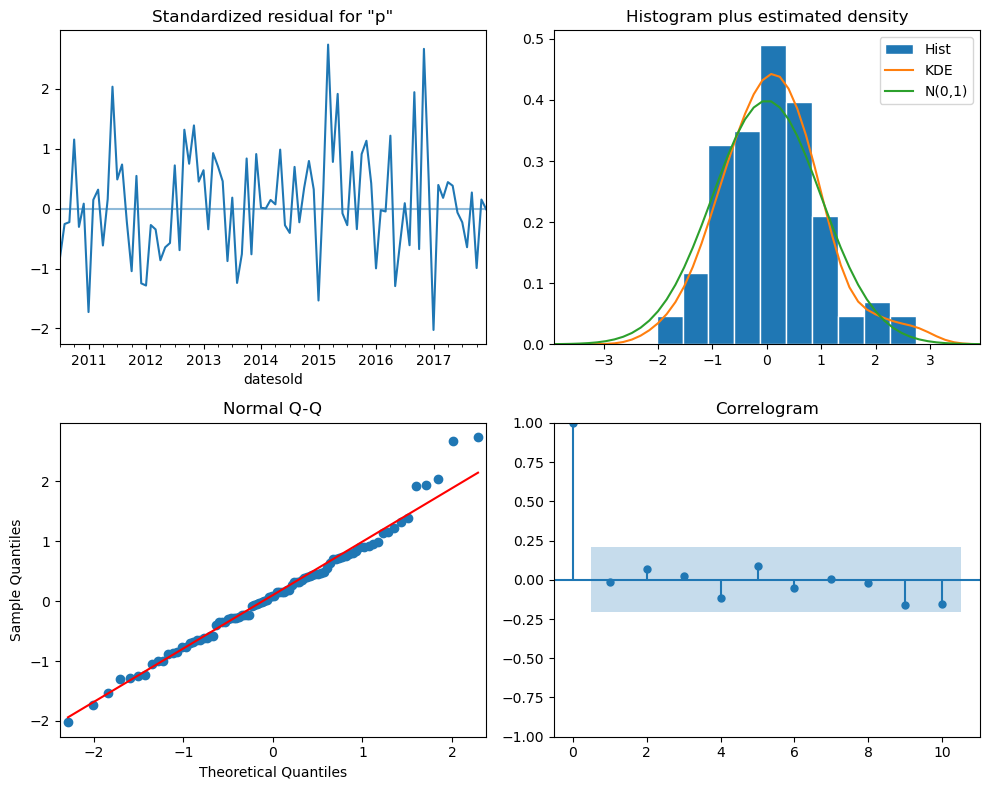

In [23]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_113.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [24]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_112 = SARIMAX(hou_series,                      # Time series data
                    order=(1, 1, 2),                 # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 12),    # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)      # Allow non-stationary behavior

# Fit the model
model_fit_112 = model_112.fit()

# Display summary of the model
print(model_fit_112.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  131
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1490.229
Date:                Fri, 09 May 2025   AIC                           2988.458
Time:                        08:34:23   BIC                           2999.835
Sample:                    02-28-2007   HQIC                          2993.081
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6213      0.021     29.244      0.000       0.580       0.663
ma.L1         -1.4398      0.044    -32.905      0.000      -1.526      -1.354
ma.L2          0.5471      0.052     10.616      0.0

In [25]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_112)

All variables are statistically relevant.


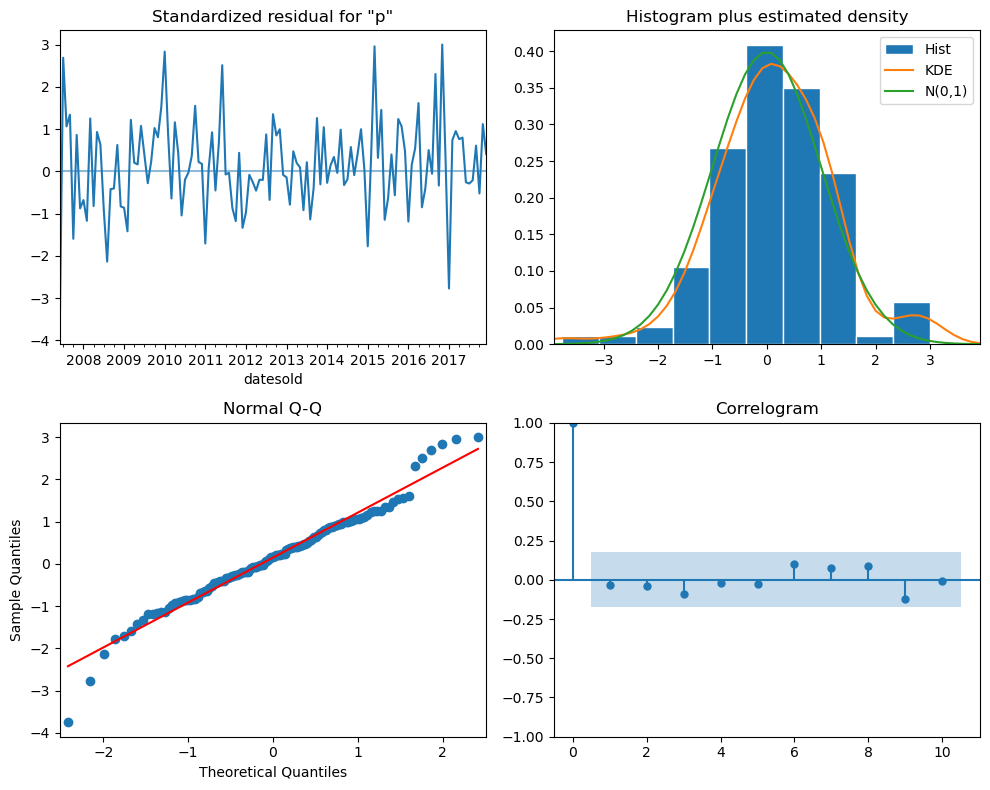

In [26]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_112.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [27]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_112.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.045537,0.831020
2,0.377636,0.827937
3,5.536970,0.136444
4,11.014931,0.026397
5,12.313974,0.030730
6,13.035798,0.042471
7,14.850703,0.037962
8,14.860986,0.061906
9,14.864255,0.094733
10,15.203878,0.124804


In [28]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.6325
Conclusion: No significant autocorrelation.


In [29]:
test.shape

(19, 1)

In [30]:
# Forecast the next Time points
forecast_S = model_fit_112.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                                # Forecast mean

test['Error'] = test['Forecast S'] - test['price']

test['Lower 95% CI'] = conf_int_S.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_S.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,price,Forecast S,Error,Lower 95% CI,Upper 95% CI
datesold,,,,,
2018-01-31,582655.10,614675.666988,32020.566988,559883.192323,669468.141652
2018-02-28,625418.85,615786.926047,-9631.923953,560099.239397,671474.612698
2018-03-31,623425.33,616477.328225,-6948.001775,559498.349992,673456.306458
2018-04-30,639740.24,616906.260761,-22833.979239,558378.120236,675434.401287
2018-05-31,626453.34,617172.747639,-9280.592361,556948.096239,677397.399039
2018-06-30,619159.48,617338.310403,-1821.169597,555345.234587,679331.386218
2018-07-31,629953.47,617441.171109,-12512.298891,553655.229441,681227.112778
2018-08-31,621530.08,617505.076331,-4025.003669,551930.125898,683080.026764
2018-09-30,634523.60,617544.779318,-16978.820682,550200.734935,684888.823701


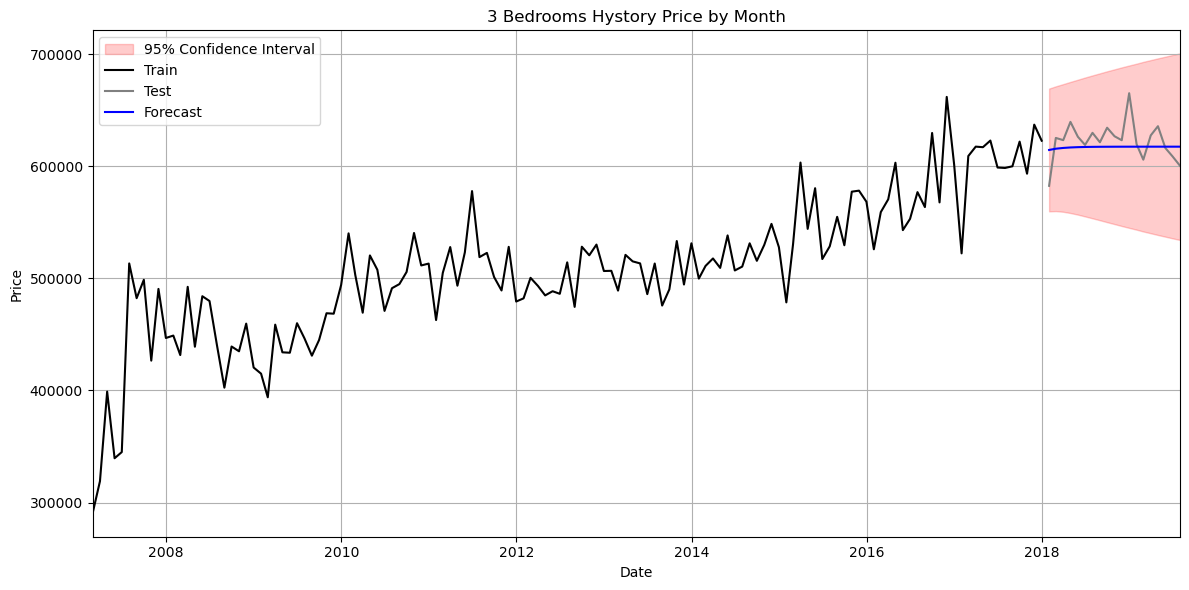

In [31]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['price'], label='Train', color='black')       # Train
plt.plot(test.index, test['price'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')    # Forecast

plt.title('3 Bedrooms Hystory Price by Month')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2007-02-28'), pd.to_datetime('2019-07-31'))

# Set y-axis to avoid scientific notation
plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX

In [32]:
bed3 = bed3m.copy()
bed3

,price
datesold,
2007-02-28,290000.00
2007-03-31,319000.00
2007-04-30,399000.00
2007-05-31,339500.00
2007-06-30,345000.00
...,...
2019-03-31,627683.91
2019-04-30,635890.68
2019-05-31,616391.79


In [33]:
# Load Dataset
ir = pd.read_csv('data/IR.csv')

ir.head()

,observation_date,REAINTRATREARAT10Y
0,1982-01-01,7.623742
1,1982-02-01,7.656648
2,1982-03-01,7.128993
3,1982-04-01,7.408347
4,1982-05-01,7.320041


In [34]:
# Rename columns
ir = ir.rename(columns={'observation_date': 'Date', 'REAINTRATREARAT10Y': 'IR'})

# Convert 'Date' column to datetime format
ir['Date'] = pd.to_datetime(ir['Date'])

# Set 'DATE' as the index
ir.set_index('Date', inplace=True)

ir.head()

,IR
Date,
1982-01-01,7.623742
1982-02-01,7.656648
1982-03-01,7.128993
1982-04-01,7.408347
1982-05-01,7.320041


In [35]:
# Create a subset of the 'ir' DataFrame for the specified date range
ir_subset = ir.loc['2007-02-01':'2019-07-01']

# Display the subset
ir_subset.head()

,IR
Date,
2007-02-01,2.287151
2007-03-01,2.024986
2007-04-01,2.077487
2007-05-01,2.031844
2007-06-01,2.246310


In [36]:
# Adjust the index of ir_subset to match the end of each month
ir_subset.index = ir_subset.index + pd.offsets.MonthEnd(0)

# Merge ir_subset into bed3m using the adjusted date index
bed3 = bed3.merge(ir_subset, left_index=True, right_index=True, how='left')

# Display the result
bed3.head()

,price,IR
datesold,,
2007-02-28,290000.0,2.287151
2007-03-31,319000.0,2.024986
2007-04-30,399000.0,2.077487
2007-05-31,339500.0,2.031844
2007-06-30,345000.0,2.246310


In [37]:
bed3.tail()

,price,IR
datesold,,
2019-03-31,627683.91,0.517208
2019-04-30,635890.68,0.420304
2019-05-31,616391.79,0.540429
2019-06-30,608900.00,0.421302
2019-07-31,600557.73,0.440572


In [38]:
# Load Dataset
inf = pd.read_csv('data/Inflation.csv')

inf

,observation_date,CPIAUCSL
0,1947-01-01,21.480
1,1947-02-01,21.620
2,1947-03-01,22.000
3,1947-04-01,22.000
4,1947-05-01,21.950
...,...,...
934,2024-11-01,316.449
935,2024-12-01,317.603
936,2025-01-01,319.086
937,2025-02-01,319.775


In [39]:
# Calculate monthly inflation rate
inf['Monthly Inflation (%)'] = inf['CPIAUCSL'].pct_change() * 100

# Display the result
inf.head()

,observation_date,CPIAUCSL,Monthly Inflation (%)
0,1947-01-01,21.48,NaN
1,1947-02-01,21.62,0.651769
2,1947-03-01,22.00,1.757632
3,1947-04-01,22.00,0.000000
4,1947-05-01,21.95,-0.227273


In [40]:
# Drop column 'CPIAUCSL'
inf = inf.drop(columns=['CPIAUCSL'])

# Rename columns
inf = inf.rename(columns={'observation_date': 'Date', 'Monthly Inflation (%)': 'Inflation'})

# Convert 'Date' column to datetime format
inf['Date'] = pd.to_datetime(inf['Date'])

# Set 'DATE' as the index
inf.set_index('Date', inplace=True)

inf

,Inflation
Date,
1947-01-01,NaN
1947-02-01,0.651769
1947-03-01,1.757632
1947-04-01,0.000000
1947-05-01,-0.227273
...,...
2024-11-01,0.280450
2024-12-01,0.364672
2025-01-01,0.466935


In [41]:
# Create a subset of the 'inf' DataFrame for the specified date range
inf_subset = inf.loc['2007-02-01':'2019-07-01']

# Display the subset
inf_subset.head()

,Inflation
Date,
2007-02-01,0.387835
2007-03-01,0.520012
2007-04-01,0.300066
2007-05-01,0.413299
2007-06-01,0.231675


In [42]:
# Adjust the index of ir_subset to match the end of each month
inf_subset.index = inf_subset.index + pd.offsets.MonthEnd(0)

# Merge ir_subset into bed3m using the adjusted date index
bed3 = bed3.merge(inf_subset, left_index=True, right_index=True, how='left')

# Display the result
bed3.head()

,price,IR,Inflation
datesold,,,
2007-02-28,290000.0,2.287151,0.387835
2007-03-31,319000.0,2.024986,0.520012
2007-04-30,399000.0,2.077487,0.300066
2007-05-31,339500.0,2.031844,0.413299
2007-06-30,345000.0,2.246310,0.231675


In [43]:
bed3

,price,IR,Inflation
datesold,,,
2007-02-28,290000.00,2.287151,0.387835
2007-03-31,319000.00,2.024986,0.520012
2007-04-30,399000.00,2.077487,0.300066
2007-05-31,339500.00,2.031844,0.413299
2007-06-30,345000.00,2.246310,0.231675
...,...,...,...
2019-03-31,627683.91,0.517208,0.378179
2019-04-30,635890.68,0.420304,0.375968
2019-05-31,616391.79,0.540429,0.024683


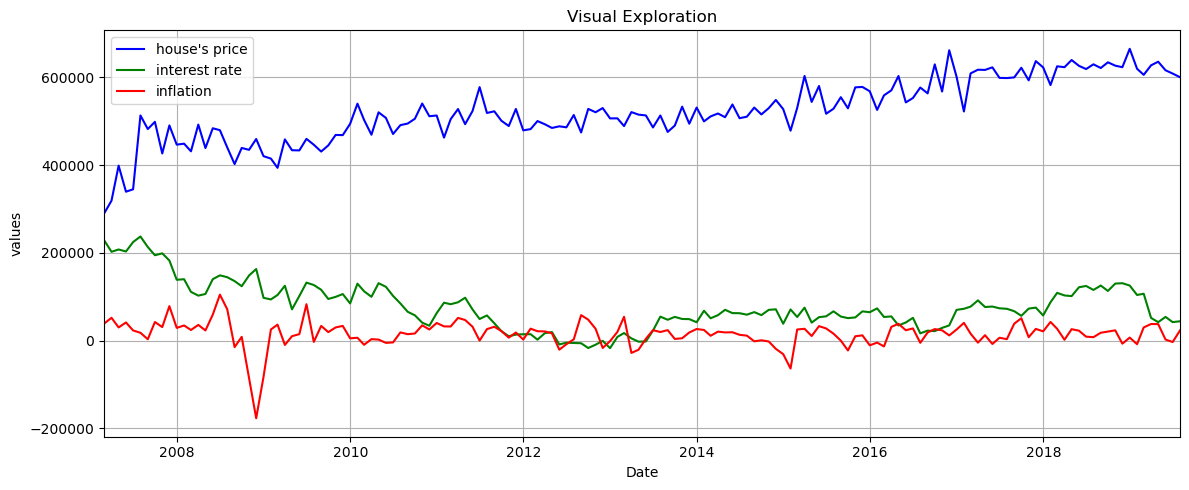

In [44]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(bed3.index, bed3['price'], label="house's price", color='blue')                   
plt.plot(bed3.index, bed3['IR']*100000, label='interest rate', color='green')     
plt.plot(bed3.index, bed3['Inflation']*100000, label='inflation', color='red') 

plt.title('Visual Exploration')                      
plt.xlabel('Date')                                        
plt.ylabel('values')  
plt.xlim(pd.to_datetime('2007-02-28'), pd.to_datetime('2019-07-31'))

#plt.ylim(0, 750)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [45]:
def create_lagged_exog(df, exog_cols, nlags):
   
    lagged = pd.DataFrame(index=df.index)

    for col in exog_cols:
        for lag in range(0, nlags + 1):                      # include lag 0 (contemporaneous)
            lagged[f'{col}_lag{lag}'] = df[col].shift(lag)

    return lagged


test_lags = ['IR','Inflation']                         # Columns selected to be lagged

exten = create_lagged_exog(bed3, test_lags, nlags=3)   # Apply lags

exten['price'] = bed3['price']                         # Bring target series
 
exten = exten[['price'] + [col for col in exten.columns if col != 'price']]   # Make 'price' the first column

exten.head()

,price,IR_lag0,IR_lag1,IR_lag2,IR_lag3,Inflation_lag0,Inflation_lag1,Inflation_lag2,Inflation_lag3
datesold,,,,,,,,,
2007-02-28,290000.0,2.287151,NaN,NaN,NaN,0.387835,NaN,NaN,NaN
2007-03-31,319000.0,2.024986,2.287151,NaN,NaN,0.520012,0.387835,NaN,NaN
2007-04-30,399000.0,2.077487,2.024986,2.287151,NaN,0.300066,0.520012,0.387835,NaN
2007-05-31,339500.0,2.031844,2.077487,2.024986,2.287151,0.413299,0.300066,0.520012,0.387835
2007-06-30,345000.0,2.246310,2.031844,2.077487,2.024986,0.231675,0.413299,0.300066,0.520012


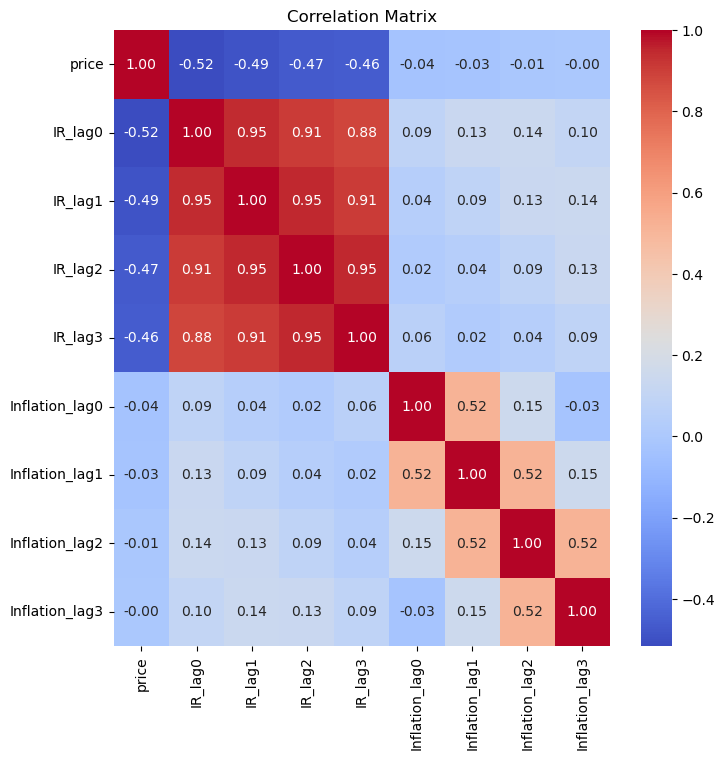

In [46]:
ts = train.shape[0]

# Display the first 131 rows (train size)
df_first_131 = exten.iloc[:ts]
df_first_131

# Compute correlation matrix
c_matrix = df_first_131.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

    In this case, lags do not improve model performance.

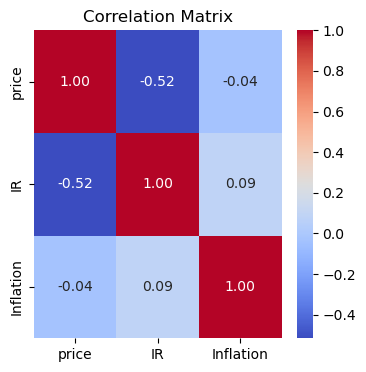

In [47]:
# Back to original dataframe (train)
c_matrix = bed3.iloc[:131].corr()

plt.figure(figsize=(4, 4))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = c_matrix.columns
vif_data["VIF"] = [round(variance_inflation_factor(c_matrix.values, i), 2) for i in range(len(c_matrix.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = c_matrix.corr().round(2)
print(f'Correlation:\n{corr}')

            VIF         Interpretation
Feature                               
price      2.99  Not Multicollinearity
IR         3.04  Not Multicollinearity
Inflation  1.03  Not Multicollinearity

Correlation:
           price    IR  Inflation
price       1.00 -0.95      -0.31
IR         -0.95  1.00      -0.01
Inflation  -0.31 -0.01       1.00


In [49]:
# Split the data
cutoff = pd.to_datetime("2018-01-01")

train2 = bed3[bed3.index < cutoff]
test2 = bed3[bed3.index >= cutoff]

# Show results
print("Train shape:", train2.shape)
print("Test shape:", test2.shape)
print()
print(train2.tail())
print()
print(test2.head())

Train shape: (131, 3)
Test shape: (19, 3)

                price        IR  Inflation
datesold                                  
2017-08-31  600104.91  0.670860   0.384863
2017-09-30  622123.16  0.565213   0.510639
2017-10-31  593466.56  0.729144   0.077505
2017-11-30  637271.15  0.752190   0.266801
2017-12-31  622931.88  0.573049   0.210689

                price        IR  Inflation
datesold                                  
2018-01-31  582655.10  0.873788   0.425334
2018-02-28  625418.85  1.088469   0.269229
2018-03-31  623425.33  1.029536   0.019236
2018-04-30  639740.24  1.014354   0.260441
2018-05-31  626453.34  1.216092   0.225795


In [50]:
exog_data = train2[['IR', 'Inflation']]  # Multiple column selection
endog_data = train2['price']             # Target variable selection

In [51]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]       # Define search ranges for non-seasonal parameters (p, q)
P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]         # Define search ranges for seasonal parameters (P, Q)
d = 1
D = 0
S = 12

total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(endog=endog_data,
                exog=exog_data,
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,model
0,183,"(2, 1, 3)","(1, 0, 3)",2101.648082,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,243,"(3, 1, 3)","(0, 0, 3)",2104.24866,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,191,"(2, 1, 3)","(3, 0, 3)",2105.273028,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,251,"(3, 1, 3)","(2, 0, 3)",2105.358135,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,187,"(2, 1, 3)","(2, 0, 3)",2105.651137,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [52]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(2, 1, 3),               
                  seasonal_order=(1, 0, 3, 12),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  131
Model:             SARIMAX(2, 1, 3)x(1, 0, 3, 12)   Log Likelihood               -1038.824
Date:                            Fri, 09 May 2025   AIC                           2101.648
Time:                                    08:43:28   BIC                           2131.646
Sample:                                02-28-2007   HQIC                          2113.745
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IR          1.608e+04   1.61e+04      0.996      0.319   -1.55e+04    4.77e+04
Inflation   4154.9073    1.3e+04   

In [53]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_M)

IR coefficient: 16077.2924
IR 95% CI: (-15544.5275, 47699.1123)
IR p-value: 0.3190
IR is statistically IRRELEVANT in the model.

Inflation coefficient: 4154.9073
Inflation 95% CI: (-21274.4392, 29584.2539)
Inflation p-value: 0.7488
Inflation is statistically IRRELEVANT in the model.

ar.L1 coefficient: 0.0431
ar.L1 95% CI: (-0.1963, 0.2825)
ar.L1 p-value: 0.7242
ar.L1 is statistically IRRELEVANT in the model.

ma.S.L24 coefficient: 0.1460
ma.S.L24 95% CI: (-0.2153, 0.5072)
ma.S.L24 p-value: 0.4285
ma.S.L24 is statistically IRRELEVANT in the model.

ma.S.L36 coefficient: 0.0963
ma.S.L36 95% CI: (-0.0660, 0.2586)
ma.S.L36 p-value: 0.2448
ma.S.L36 is statistically IRRELEVANT in the model.



In [54]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(1, 1, 2),               
                  seasonal_order=(0, 0, 0, 12),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  131
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1489.872
Date:                Fri, 09 May 2025   AIC                           2991.745
Time:                        08:43:29   BIC                           3008.810
Sample:                    02-28-2007   HQIC                          2998.678
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IR          1.608e+04   1.12e+04      1.441      0.150   -5797.290     3.8e+04
Inflation   4154.9071   7499.308      0.554      0.580   -1.05e+04    1.89e+04
ar.L1          0.6588      0.029     22.635      0.0

In [55]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")


test_parameters(model_fit_M)

IR coefficient: 16077.2938
IR 95% CI: (-5797.2900, 37951.8775)
IR p-value: 0.1497
IR is statistically IRRELEVANT in the model.

Inflation coefficient: 4154.9071
Inflation 95% CI: (-10543.4664, 18853.2806)
Inflation p-value: 0.5796
Inflation is statistically IRRELEVANT in the model.



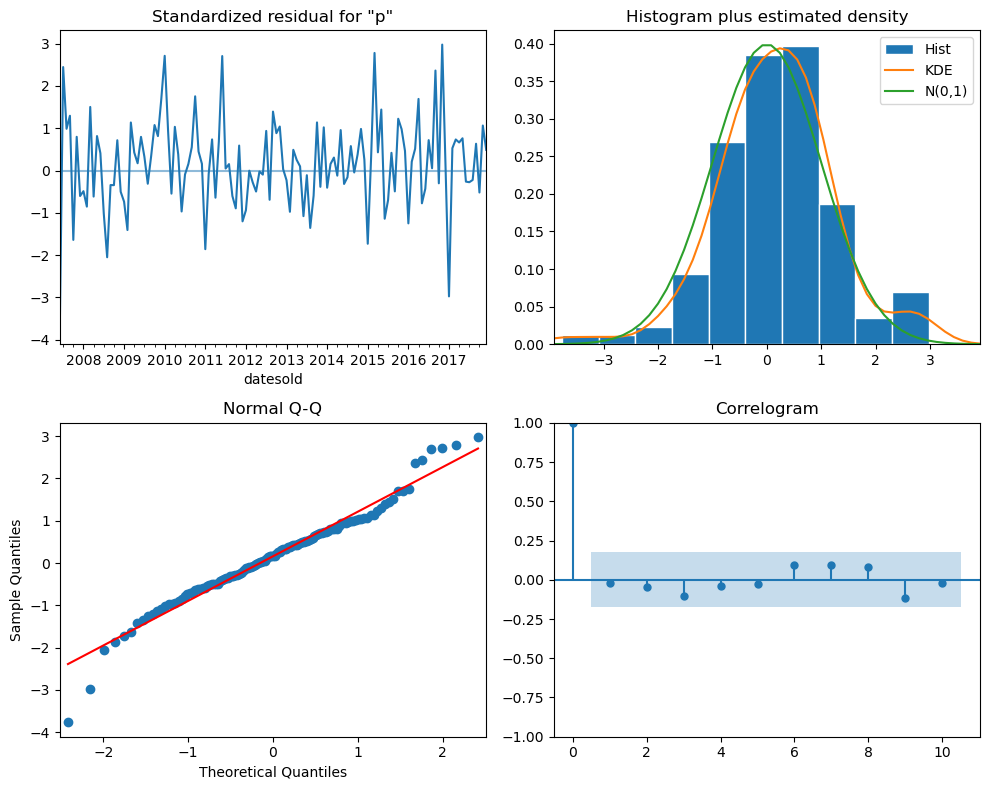

In [56]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [57]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,4.721780e-09,0.999945
2,3.244545e-01,0.850248
3,5.583747e+00,0.133715
4,1.157645e+01,0.020795
5,1.260065e+01,0.027423
6,1.329500e+01,0.038583
7,1.537532e+01,0.031478
8,1.539611e+01,0.051886
9,1.545503e+01,0.079172
10,1.586375e+01,0.103600


In [58]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.6487
Conclusion: No significant autocorrelation.


In [59]:
# Must match the structure of training exog
exog_test_M = test2[['IR', 'Inflation']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test2.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test2['Forecast M'] = forecast_mean_M.values
test2['Error M'] = test2['Forecast M'] - test2['price']
test2['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test2['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test2.head()

,price,IR,Inflation,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
datesold,,,,,,,
2018-01-31,582655.10,0.873788,0.425334,618343.337828,35688.237828,563187.815941,673498.859715
2018-02-28,625418.85,1.088469,0.269229,622383.294523,-3035.555477,566424.638872,678341.950173
2018-03-31,623425.33,1.029536,0.019236,621212.051429,-2213.278571,564062.493546,678361.609311
2018-04-30,639740.24,1.014354,0.260441,622507.016290,-17233.223710,563891.175237,681122.857344
2018-05-31,626453.34,1.216092,0.225795,625960.126869,-493.213131,565703.517444,686216.736295


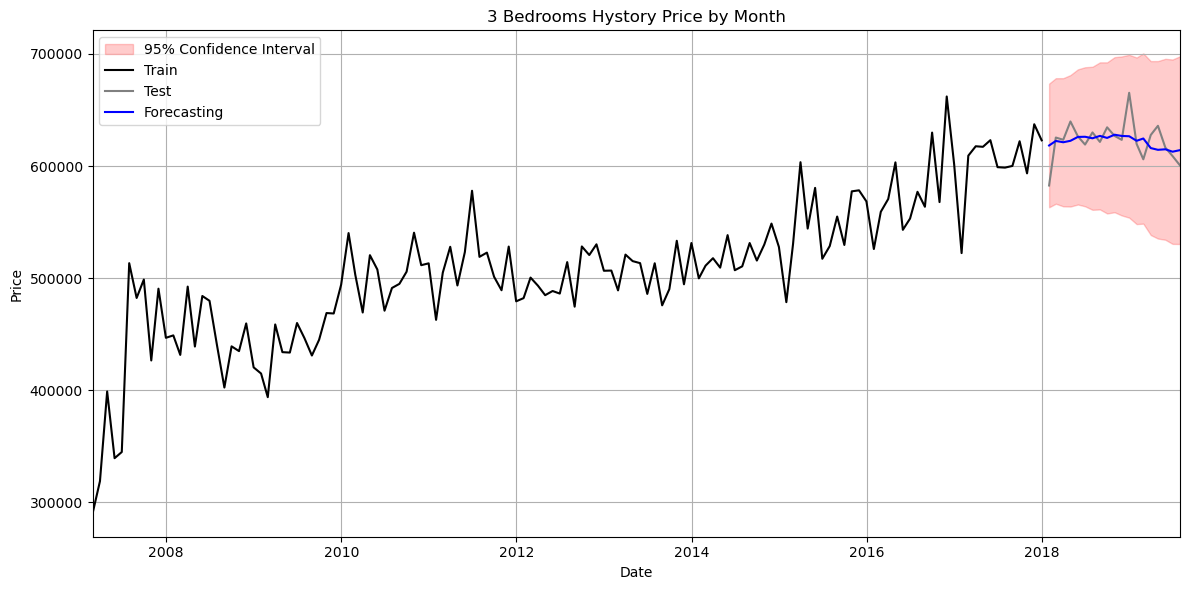

In [60]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train2.index, train2['price'], label='Train', color='black')                      
plt.plot(test2.index, test2['price'], label='Test', color='gray')     
plt.plot(test2.index, test2['Forecast M'], label='Forecasting', color='blue') 

plt.title('3 Bedrooms Hystory Price by Month')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2007-02-28'), pd.to_datetime('2019-07-31'))

# Set y-axis to avoid scientific notation
plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['price'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['price'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['price'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test2['price'], test2['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test2['price'], test2['Forecast M']))
mape_m = mean_absolute_percentage_error(test2['price'], test2['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    'MAPE': mape_m,
}

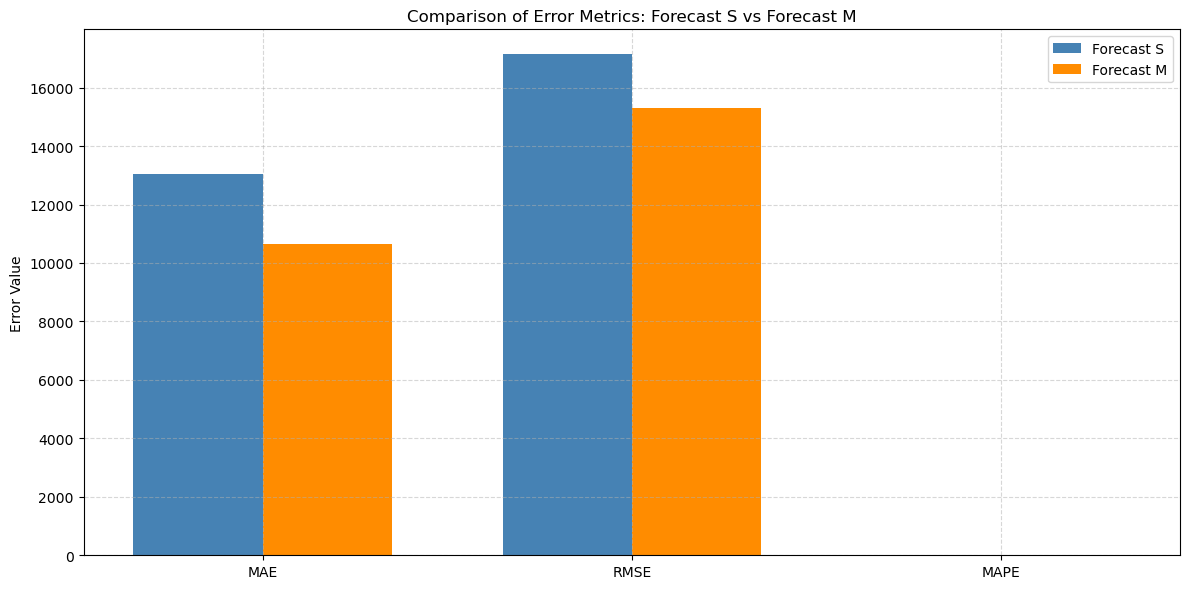

In [62]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [63]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,13051.06,10644.72
RMSE,17136.73,15290.70
MAPE,2.08,1.71


##### Interpreting MAPE Values:

    MAPE 2.08: This means that the model's predictions are, on average, 2.08% off from the actual values.

    MAPE 1.71: This means that the model's predictions are, on average, 1.71% off from the actual values.

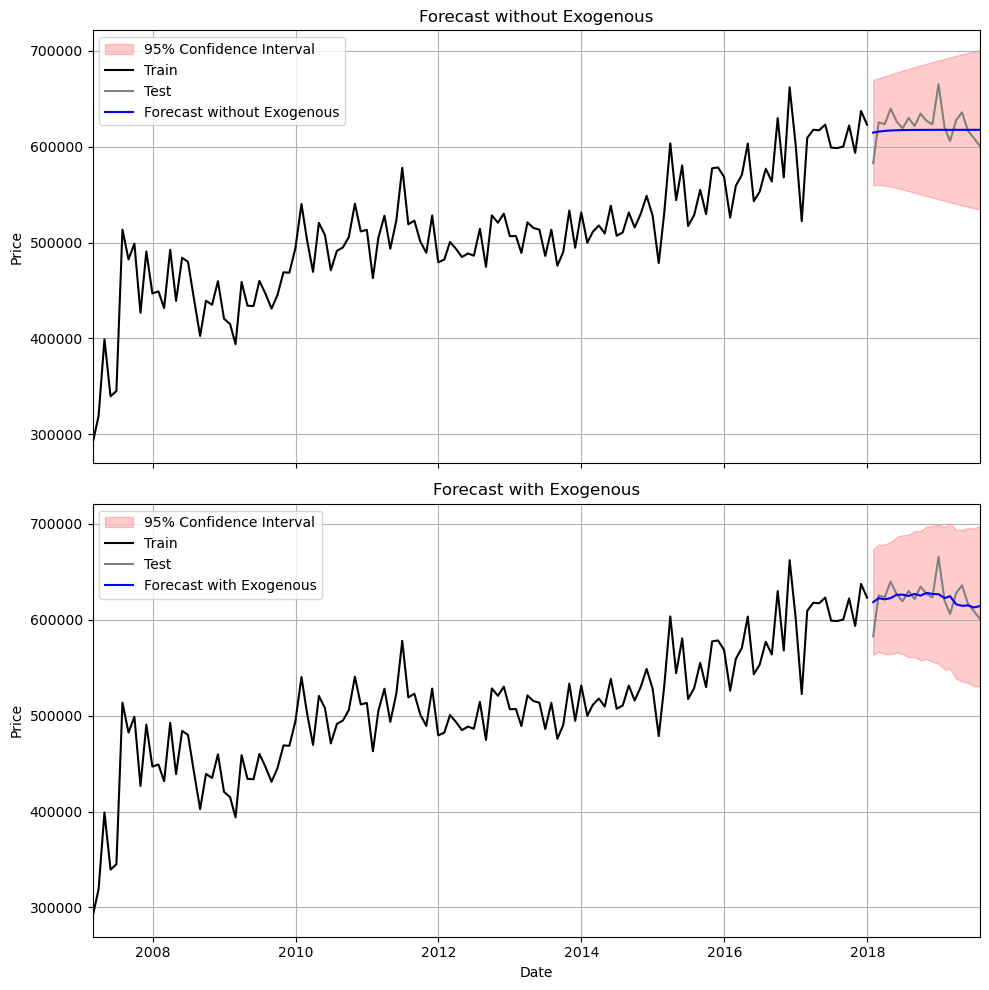

In [64]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast103) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['price'], label='Train', color='black')
axes[0].plot(test.index, test['price'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2007-02-28'), pd.to_datetime('2019-07-31'))
#axes[0].set_ylim(0, 60)

# --- Second Forecast (ForecastM) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train2.index, train2['price'], label='Train', color='black')
axes[1].plot(test2.index, test2['price'], label='Test', color='gray')
axes[1].plot(test2.index, test2['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2007-02-28'), pd.to_datetime('2019-07-31'))
#axes[1].set_ylim(0, 60)

# Final layout
plt.tight_layout()
plt.show()

End.